# 0 Getting data and installing libraries

## Getting data and unzipping

In [ ]:
# !wget https://www.kaggle.com/api/v1/datasets/download/prasunroy/natural-images

In [ ]:
# !unzip natural-images

## Requirments installation

In [1]:
!nvidia-smi

Mon Jan 13 15:23:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.12              Driver Version: 550.90.12      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       On  |   00000000:00:1E.0 Off |                    0 |
| N/A   27C    P8             11W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install 'tensorflow[and-cuda]'

In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2025-01-13 15:24:13.411608: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-13 15:24:13.429484: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736781853.449905    9503 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736781853.456115    9503 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-13 15:24:13.476442: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Num GPUs Available:  1


In [4]:
!pip3 install pandas numpy ipyplot split-folders matplotlib scipy==1.11.4 pydot

# 1 EDA

In [5]:
import os
import numpy as np
import scipy
from tensorflow import keras
from PIL import Image

In [6]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

## 1.1 Let's take a look at couple of images

In [7]:
from keras.utils import load_img

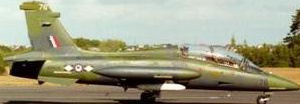

In [8]:
load_img('data/natural_images/airplane/airplane_0000.jpg')

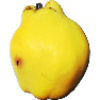

In [9]:
load_img('data/natural_images/fruit/fruit_0002.jpg')

## 1.2 All different classes:

In [10]:
images_folder = 'data/natural_images/'
image_classes = os.listdir(images_folder)
print(f"All image classes: {image_classes}")

All image classes: ['airplane', 'person', 'flower', 'fruit', 'cat', 'dog', 'car', 'motorbike']



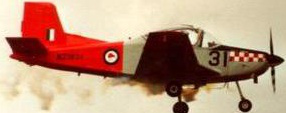
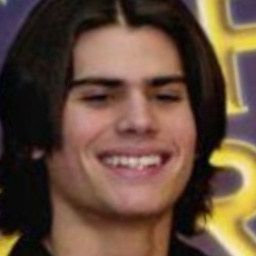
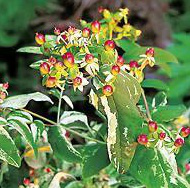
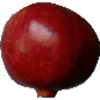
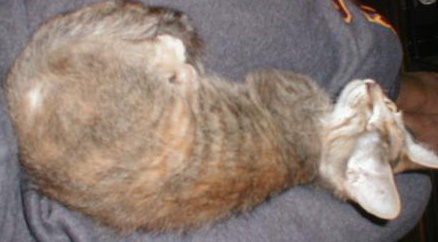
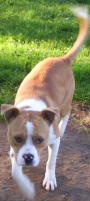
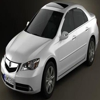
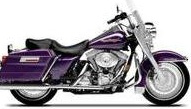


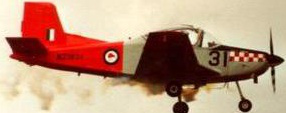
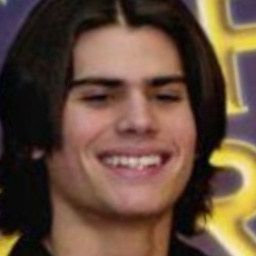
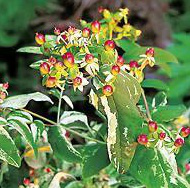
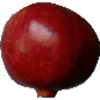
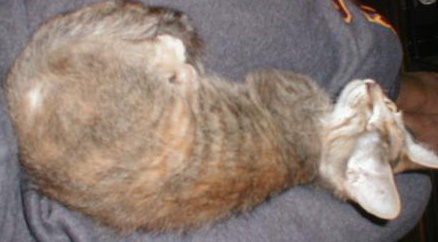
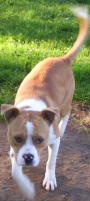
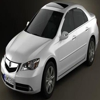
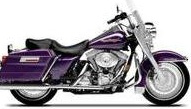

In [11]:
import ipyplot
images_array = [Image.open(f"{images_folder}/{class_name}/{class_name}_0001.jpg") for class_name in image_classes]
ipyplot.plot_images(images_array, labels=image_classes)

## 1.3 Let's see how many images of each class we have

In [12]:
classes_sizes = {}
for class_name in image_classes:
    class_size = len(os.listdir(images_folder + '/' + class_name))
    classes_sizes[class_name] = class_size

<BarContainer object of 8 artists>

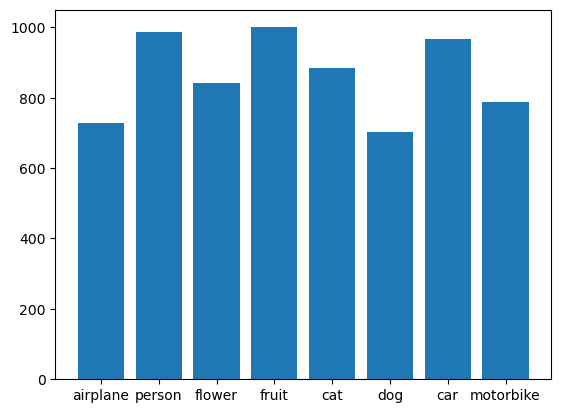

In [13]:
from matplotlib import pyplot as plt
plt.bar(*zip(*classes_sizes.items()))

In [14]:
biggest_class = max(classes_sizes, key=classes_sizes.get)
smallest_class = min(classes_sizes, key=classes_sizes.get)
print(f"Biggest class is {biggest_class} with {classes_sizes[biggest_class]}")
print(f"Small class is {smallest_class} with {classes_sizes[smallest_class]}")

Biggest class is fruit with 1000
Small class is dog with 702


It looks like classes are pretty ballanced.

### 1.4 Let's look at images sizes:

In [15]:
for image in images_array:
    print(np.array(image).shape)

(113, 286, 3)
(256, 256, 3)
(188, 190, 3)
(100, 100, 3)
(242, 438, 3)
(201, 90, 3)
(100, 100, 3)
(109, 191, 3)


Seems like all images have different sizes. During the training (and fine tuning) let's makes them all 150 by 150 and then after let's make them 299 by 299 to test on test dataset

# 2. Train test split

Let's split our data to train, validation and test with 60%, 20% and 20% of each class. We will also shuffle images during splitting.

In [17]:
import splitfolders
import shutil

input_folder = images_folder
output_folder = "prepared_data"
if os.path.exists(output_folder):
    shutil.rmtree(output_folder)

splitfolders.ratio(input_folder, output=output_folder, seed=SEED, ratio=(0.6, 0.2, 0.2))

# 3. Prepare data for training and testing

In [18]:
from keras.applications.xception import Xception
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.imagenet_utils import decode_predictions

We need to resize the image to 299x299 for it to be used with imagenet

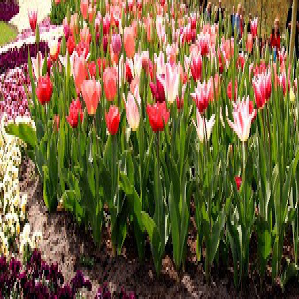

In [19]:
image_path = f"{output_folder}/train/flower/"
fullpath = image_path + os.listdir(image_path)[0]
image = load_img(fullpath, target_size=(299, 299))
image

In [20]:
print(image)

<PIL.Image.Image image mode=RGB size=299x299 at 0x7F2B2926F0A0>


In [21]:
x = np.array(image)
x.shape

(299, 299, 3)

In [22]:
X = np.array([x]) 

In [23]:
X = preprocess_input(X)

In [24]:
# Let's load original model and look at her predictions
model = Xception(weights='imagenet', input_shape=(299, 299, 3))

I0000 00:00:1736781943.803214    9503 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5


In [25]:
pred = model.predict(X)

I0000 00:00:1736781946.843975    9637 service.cc:148] XLA service 0x7f2a34002bf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736781946.844006    9637 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-01-13 15:25:46.879535: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1736781947.191255    9637 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-13 15:25:48.317543: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


I0000 00:00:1736781949.154230    9637 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [26]:
decode_predictions(pred)

[[('n03814906', 'necklace', 0.9150287),
  ('n04153751', 'screw', 0.061060958),
  ('n03942813', 'ping-pong_ball', 0.01807146),
  ('n02834397', 'bib', 0.0038628941),
  ('n04517823', 'vacuum', 0.0004282998)]]

This prediction is a complete nonsence. So we will have to train Dense layers of imagenet onse again on our classes

In [27]:
train_ds = keras.utils.image_dataset_from_directory(
    directory=f'{output_folder}/train',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(150, 150)
)
val_ds = keras.utils.image_dataset_from_directory(
    directory=f'{output_folder}/val',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(150, 150)
)

Found 4136 files belonging to 8 classes.
Found 1377 files belonging to 8 classes.


# Models

## We gonna do the same thing we did during lecture 8. 
Take Imagenet as basis, delete top of the model (dense layers) and train them once again on our classes. 

In [28]:
base_model = Xception(
    weights='imagenet', 
    include_top=False,
    input_shape=(150, 150, 3)
)

base_model.trainable = False # We don't want to retrain the model

In [29]:
inputs = keras.Input(shape=(150, 150, 3))
base = base_model(inputs)

In [34]:
outputs = base

model = keras.Model(inputs, outputs)

In [35]:
s = train_ds.take(1)
print(s)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 8), dtype=tf.float32, name=None))>


In [36]:
preds = model.predict(s)
preds.shape # outputs (32, 5, 5, 2048)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


(32, 5, 5, 2048)

In [37]:
def make_model_0(learning_rate=0.1):
    base_model = Xception(
        weights='imagenet', 
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False 

    #############################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(8)(vectors)
    model = keras.Model(inputs, outputs)

    #############################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True) 

    model.compile(
        optimizer=optimizer, 
        loss=loss, 
        metrics=['accuracy']
    )

    return model

In [38]:
scores = {}
lr = 0.001
model = make_model_0(learning_rate = lr)
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 20s 113ms/step - accuracy: 0.3948 - loss: 6.0761 - val_accuracy: 0.6587 - val_loss: 1.6865
Epoch 2/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.6955 - loss: 1.4728 - val_accuracy: 0.7059 - val_loss: 1.3840
Epoch 3/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.7433 - loss: 1.0802 - val_accuracy: 0.7487 - val_loss: 1.1698
Epoch 4/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.8003 - loss: 0.8181 - val_accuracy: 0.7705 - val_loss: 0.9816
Epoch 5/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.8236 - loss: 0.6632 - val_accuracy: 0.7502 - val_loss: 1.1180
Epoch 6/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.8257 - loss: 0.6721 - val_accuracy: 0.7850 - val_loss: 0.9552
Epoch 7/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.8417 - loss: 0.5951 - val_accuracy: 0.7778 - val_loss: 1.0109
Epoch 8/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.8486 - loss: 0.5405 - val_ac

In [39]:
scores[lr] = history.history

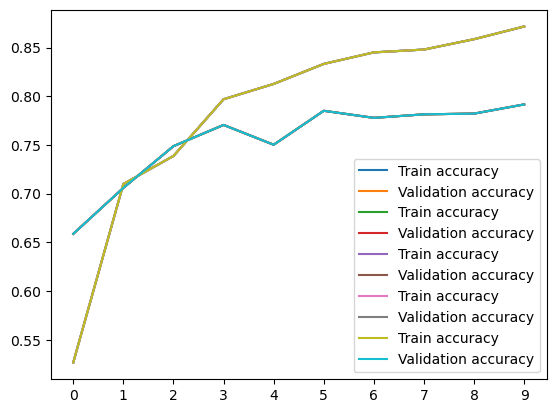

In [49]:
for lr, hist in scores.items():
    plt.plot(scores[0.001]['accuracy'], label='Train accuracy')
    plt.plot(scores[0.001]['val_accuracy'], label='Validation accuracy')
    
plt.xticks(np.arange(10))
plt.legend()

In [41]:
max(scores[0.001]['val_accuracy'])

0.7915759086608887

We can see that top accuracy for validation dataset was reached during epoch 6 with val_accuracy equal to 79.7%. 
After epoch 6 model start to be heavily overfitted.

# Parameters tuning

## Let's try training model with different learning rates

In [44]:
for lr in [0.0001, 0.01, 0.1, 1.0]:
    print(lr)
    model = make_model_0(learning_rate = lr)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[lr] = history.history

1.0
Epoch 1/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 18s 100ms/step - accuracy: 0.4478 - loss: 2837.1462 - val_accuracy: 0.6035 - val_loss: 947.5620
Epoch 2/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.6955 - loss: 795.0377 - val_accuracy: 0.7219 - val_loss: 621.3975
Epoch 3/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.7669 - loss: 496.7035 - val_accuracy: 0.6747 - val_loss: 848.8180
Epoch 4/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.7818 - loss: 441.8336 - val_accuracy: 0.6885 - val_loss: 1087.9800
Epoch 5/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.7766 - loss: 621.0078 - val_accuracy: 0.7451 - val_loss: 935.1827
Epoch 6/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.8052 - loss: 465.4370 - val_accuracy: 0.7836 - val_loss: 634.5140
Epoch 7/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.8313 - loss: 341.3452 - val_accuracy: 0.7865 - val_loss: 723.7581
Epoch 8/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accura

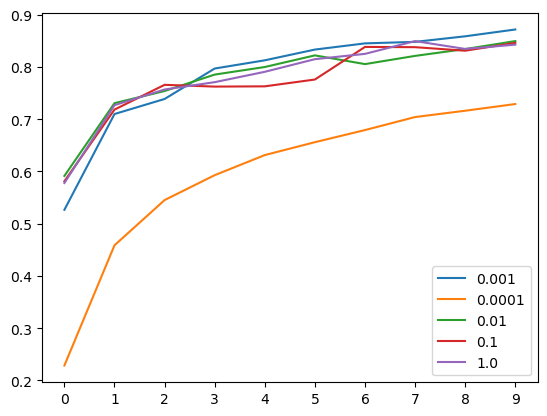

In [50]:
for lr, hist in scores.items():
    plt.plot(hist['accuracy'], label=f'{lr}')
    
plt.xticks(np.arange(10))
plt.legend()

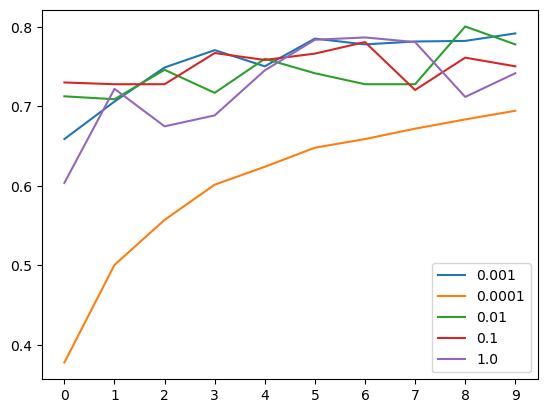

In [51]:
for lr, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=f'{lr}')
    
plt.xticks(np.arange(10))
plt.legend()

We can see that most of the learning rates give similar results, but 0.01 gets lucky on iteration 8. In my opinion lr = 0.001 gives the highest and the most stable result, so we will use it. 

In [62]:
max(scores[0.001]['val_accuracy'])

0.7915759086608887

In [53]:
best_lr = 0.001

### Let's also try changing dense layers structure

In [54]:
def make_model_1(learning_rate=0.1, inner_layer_size=100):
    base_model = Xception(
        weights='imagenet', 
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False 

    #############################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner_layer = keras.layers.Dense(inner_layer_size, activation='relu')(vectors)
    outputs = keras.layers.Dense(8)(inner_layer)
    model = keras.Model(inputs, outputs)

    #############################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True) 

    model.compile(
        optimizer=optimizer, 
        loss=loss, 
        metrics=['accuracy']
    )

    return model

In [55]:
model = make_model_1(learning_rate=best_lr, inner_layer_size=100)
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 19s 105ms/step - accuracy: 0.4918 - loss: 5.4919 - val_accuracy: 0.7001 - val_loss: 1.1331
Epoch 2/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.6946 - loss: 1.1595 - val_accuracy: 0.7037 - val_loss: 1.1024
Epoch 3/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.7766 - loss: 0.7511 - val_accuracy: 0.7611 - val_loss: 0.7999
Epoch 4/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.8108 - loss: 0.6186 - val_accuracy: 0.7429 - val_loss: 1.0635
Epoch 5/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.8264 - loss: 0.5490 - val_accuracy: 0.7683 - val_loss: 0.8849
Epoch 6/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.8248 - loss: 0.5170 - val_accuracy: 0.7879 - val_loss: 0.8414
Epoch 7/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.8678 - loss: 0.3939 - val_accuracy: 0.7603 - val_loss: 0.9216
Epoch 8/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.8591 - loss: 0.3916 - val_ac

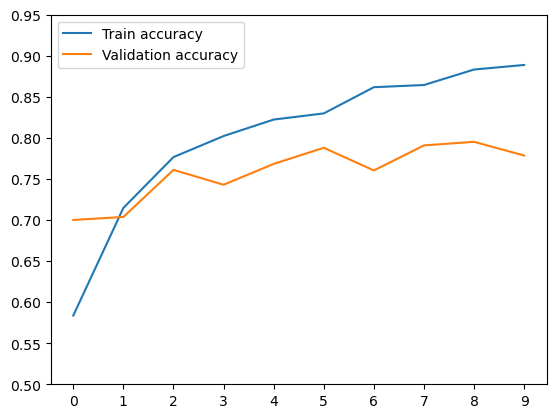

In [59]:
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    
plt.xticks(np.arange(10))
plt.yticks(np.arange(0.5,1,0.05))
plt.legend()

In [60]:
max(history.history['val_accuracy'])

0.7952069640159607

It seems to improve our results just a little bit: 79.5%

### Maybe let's play with dense layer size

In [65]:
scores = {}
for ils in [100, 200, 500, 1000]:
    print(ils)
    model = make_model_1(learning_rate=best_lr, inner_layer_size=ils)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[ils] = history.history

100
Epoch 1/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 18s 101ms/step - accuracy: 0.4857 - loss: 4.4815 - val_accuracy: 0.6093 - val_loss: 1.7613
Epoch 2/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.7065 - loss: 1.2028 - val_accuracy: 0.7473 - val_loss: 0.8697
Epoch 3/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.7895 - loss: 0.6933 - val_accuracy: 0.7574 - val_loss: 0.8165
Epoch 4/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.8188 - loss: 0.5739 - val_accuracy: 0.7480 - val_loss: 0.9041
Epoch 5/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.8178 - loss: 0.5470 - val_accuracy: 0.7821 - val_loss: 0.7513
Epoch 6/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.8309 - loss: 0.4705 - val_accuracy: 0.7800 - val_loss: 0.8202
Epoch 7/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.8721 - loss: 0.3567 - val_accuracy: 0.7821 - val_loss: 0.7850
Epoch 8/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.8657 - loss: 0.3768 - va

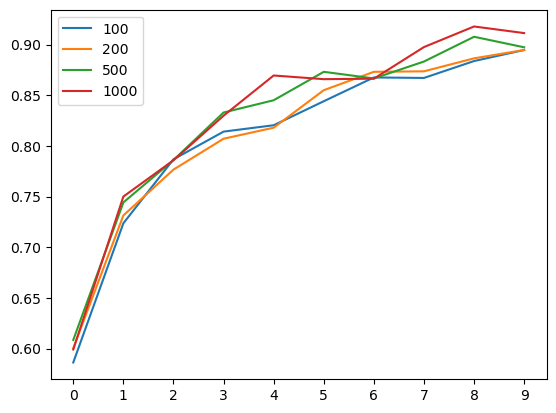

In [85]:
for ils, hist in scores.items():
    plt.plot(hist['accuracy'], label=f'{ils}')
    
plt.xticks(np.arange(10))
# plt.ylim(0.8, 0.9)
# plt.yticks(np.arange(0.7,0.95, 0.02))
plt.legend()

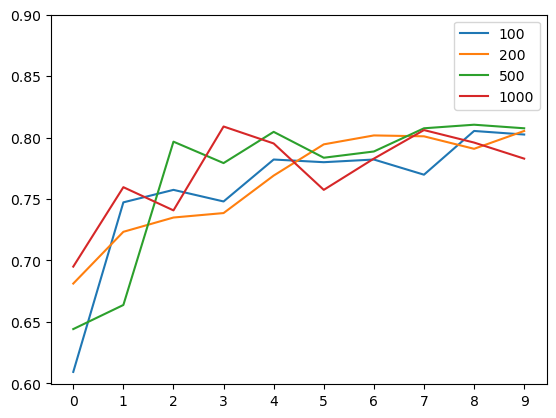

In [70]:
for ils, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=f'{ils}')
    
plt.xticks(np.arange(10))
plt.yticks(np.arange(0.6,0.9,0.05))
plt.legend()

Results are really similar, but in some cases they cross 80% line. 

In [73]:
for ils, hist in scores.items():
    print(f"{ils}, {max(hist['val_accuracy'])}")

100, 0.805374026298523
200, 0.805374026298523
500, 0.8104575276374817
1000, 0.809005081653595


Inner layer of size 500 seems to be getting the best result for epoch 9.

In [86]:
best_ils = 500

## Let's try using dropout

In [87]:
def make_model_2(learning_rate=0.1, inner_layer_size=100, droprate=0.2):
    base_model = Xception(
        weights='imagenet', 
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False 

    #############################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner_layer = keras.layers.Dense(100, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner_layer)
    outputs = keras.layers.Dense(8)(drop)
    model = keras.Model(inputs, outputs)

    #############################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True) 

    model.compile(
        optimizer=optimizer, 
        loss=loss, 
        metrics=['accuracy']
    )

    return model

In [94]:
scores = {}

for droprate in [0.0, 0.2, 0.5, 0.8]:
    print(droprate)
    model = make_model_2(
        learning_rate=best_lr,
        inner_layer_size=best_ils,
        droprate=droprate
    )
    # we increased number of epochs because we added regularization, which means model will learn slower with each epoch.
    history = model.fit(train_ds, epochs=30, validation_data=val_ds)
    scores[droprate] = history.history

0.0
Epoch 1/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 18s 99ms/step - accuracy: 0.4706 - loss: 5.1916 - val_accuracy: 0.6790 - val_loss: 1.0592
Epoch 2/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.7142 - loss: 0.8776 - val_accuracy: 0.7168 - val_loss: 0.8892
Epoch 3/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.7629 - loss: 0.6791 - val_accuracy: 0.7466 - val_loss: 0.7989
Epoch 4/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.8033 - loss: 0.5432 - val_accuracy: 0.7712 - val_loss: 0.7070
Epoch 5/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.8342 - loss: 0.4554 - val_accuracy: 0.7618 - val_loss: 0.7145
Epoch 6/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.8430 - loss: 0.4650 - val_accuracy: 0.7829 - val_loss: 0.6785
Epoch 7/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.8585 - loss: 0.3772 - val_accuracy: 0.7691 - val_loss: 0.7068
Epoch 8/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.8745 - loss: 0.3469 - val

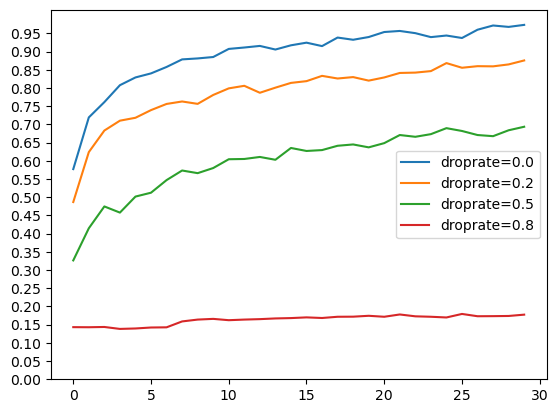

In [102]:
for droprate, hist in scores.items():
    plt.plot(hist['accuracy'], label=f'droprate={droprate}')
    
plt.yticks(np.arange(0.0, 1, 0.05))
plt.legend()

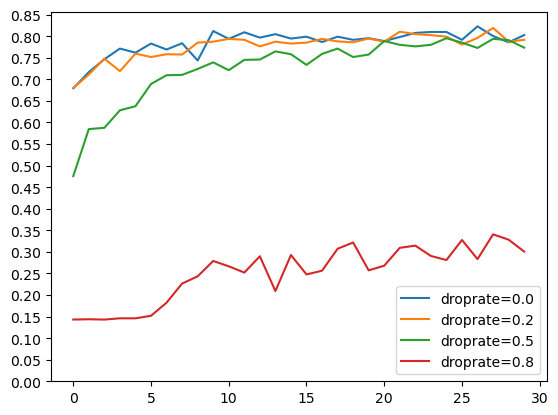

In [100]:
for droprate, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=f'droprate={droprate}')
    
plt.yticks(np.arange(0.0, 0.9, 0.05))
plt.legend()

It seems like droprate of 0.8 gives terrible result, but other droprates are similar in performace. For this reason let's leave droprate ar 0.2

In [104]:
print(max(scores[0.2]['val_accuracy']))

0.8191720843315125


In [105]:
best_droprate = 0.2

We see that best accuracy at this point is 81.9%

### Let's also try augmenting our images

In [ ]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocessing_input,
    rotation_range=30, # selects range between [-30 to 30]
    width_shift_range=10.0,
    height_shift_range=10.0,
    shear_range=10.0,
    zoom_range=0.1, # selects range between [0.9 to 1.1]
    vertical_flip=True,
)

In [ ]:
train_ds = keras.utils.image_dataset_from_directory(
    directory=f'{output_folder}/train',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(150, 150)
)
val_ds = keras.utils.image_dataset_from_directory(
    directory=f'{output_folder}/val',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(150, 150)
)

In [ ]:
def make_model_3(learning_rate=0.1, inner_layer_size=100, droprate=0.2):
    data_augmentation = tf.keras.Sequential(
        [
          layers.RandomFlip("horizontal_and_vertical"),
          layers.RandomRotation(0.2),
        ]
    )
    
    base_model = Xception(
        weights='imagenet', 
        include_top=False,
        input_shape=(150, 150, 3)
    )

    base_model.trainable = False 

    #############################

    inputs = keras.Input(shape=(150, 150, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    
    inner_layer = keras.layers.Dense(100, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner_layer)
    outputs = keras.layers.Dense(8)(drop)
    model = keras.Model(inputs, outputs)

    #############################

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True) 

    model.compile(
        optimizer=optimizer, 
        loss=loss, 
        metrics=['accuracy']
    )

    return model

## Let's also try some sequential model

In [114]:
def make_model_seq(learning_rate=0.1, droprate=0.25):
    model = keras.Sequential()
    # inputs = keras.Input(shape=(input_size, input_size, 3))

    model.add(keras.layers.Conv2D(filters=64, kernel_size=(7,7), activation='relu', input_shape=(150, 150, 3)))
    model.add(keras.layers.MaxPool2D(pool_size=(2, 2)))
    model.add(keras.layers.Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
    model.add(keras.layers.MaxPool2D(pool_size=(2, 2)))
    model.add(keras.layers.Dropout(rate=droprate))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(200, activation='relu'))
    model.add(keras.layers.Dropout(rate=droprate))
    model.add(keras.layers.Dense(8, activation='softmax'))
    
    # optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
     
    # loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False) 
    
    model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
    )
    
    # model.compile(
    #     optimizer=optimizer, 
    #     loss=loss, 
    #     metrics=['accuracy']
    # )

    return model

In [115]:
model = make_model_seq(learning_rate=0.1, droprate=0.25)

/opt/saturncloud/envs/saturn/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


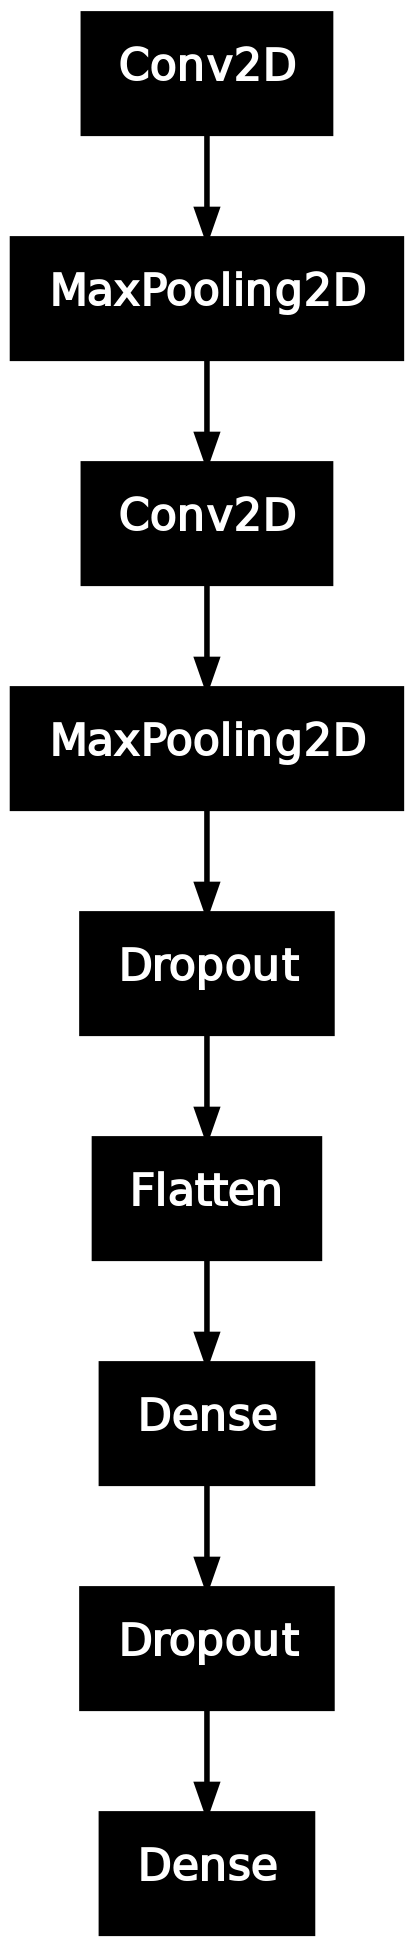

In [116]:
keras.utils.plot_model(model)

In [117]:
# history = model.fit(X_train, Y_train, epochs=20, validation_split=0.2)
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.3150 - loss: 98.6496 - val_accuracy: 0.5221 - val_loss: 1.4080
Epoch 2/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.5667 - loss: 1.3230 - val_accuracy: 0.5592 - val_loss: 1.7308
Epoch 3/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.6749 - loss: 1.0198 - val_accuracy: 0.5200 - val_loss: 1.4396
Epoch 4/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.7140 - loss: 0.8318 - val_accuracy: 0.6427 - val_loss: 1.1547
Epoch 5/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.7758 - loss: 0.6377 - val_accuracy: 0.2092 - val_loss: 2.1310
Epoch 6/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.2864 - loss: 1.8823 - val_accuracy: 0.5679 - val_loss: 1.6828
Epoch 7/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.4901 - loss: 1.5500 - val_accuracy: 0.5955 - val_loss: 1.4937
Epoch 8/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.7777 - loss: 0.6791 - val_ac

In [ ]:
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xticks(range(10))
plt.yticks(np.arange(0.5,1,0.05))
plt.legend()

In [ ]:
max(history.history['val_accuracy'])

We can see that model reaches it's peak at iteration 3, with accuracy 82.4%

# Finaly let's train fine tuned model 1 and model 2 on bigger images 299x299